# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [2]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [3]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm.invoke(messages)

AIMessage(content='Great question, Lance! Ocean mammals are a fascinating group of animals. Here are a few more ocean mammals you might want to learn about:\n\n1. **Dolphins**: These intelligent and social creatures are known for their playful behavior and complex communication skills. There are several species of dolphins, including the bottlenose dolphin and the common dolphin.\n\n2. **Porpoises**: Similar to dolphins but typically smaller and stouter, porpoises are less well-known but equally interesting. The harbor porpoise is one example.\n\n3. **Seals**: These include both true seals (like the harbor seal) and eared seals (which include sea lions and fur seals). They are known for their ability to live both in the water and on land.\n\n4. **Sea Lions**: These are a type of eared seal, easily recognized by their external ear flaps and their ability to "walk" on land using their large flippers.\n\n5. **Walruses**: Known for their distinctive long tusks and whiskers, walruses are so

We can run our chat model in a simple graph with `MessagesState`.

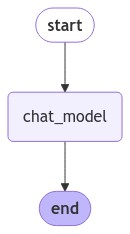

In [5]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Absolutely, whales are fascinating! But there are many other ocean mammals worth learning about. Here are a few you might find interesting:

1. **Dolphins**: Highly intelligent and social, dolphins are known for their playful behavior and complex communication. There are many species, including the bottlenose dolphin and the orca (killer whale), which is actually the largest member of the dolphin family.

2. **Seals and Sea Lions**: These pinnipeds are often found lounging on beaches or frolicking in the water. Seals tend to be more solitary, while sea lions are social and known for their barking calls.

3. **Man